In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
%reload_ext autoreload
%autoreload 2
from HelperFunctions import feature_standardize, label_encode_column, columns_of_type

from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
reg = RandomForestRegressor()
clf = RandomForestClassifier()

In [2]:
temp_df=pd.read_csv('Sampled_Dataset_Balanced.csv')
df=temp_df.sample(50000,random_state=0)

temp_pre_df=pd.read_csv('pre_downsample_df.csv')
pre_df=temp_pre_df.sample(50000,random_state=0)

holdout=pd.read_csv('Holdout_Dataset.csv')
holdout.issue_d=pd.to_datetime(holdout.issue_d)
finaldf=holdout.loc[holdout.issue_d>'2018-01',:]

In [3]:
drop_list=['sub_grade','duration','loan_status','return_rate','weight','total_payout']
#targets: duration (reg), loan_status (clf), return_rate

In [4]:
grade_weight_dict={'A':1,
            'B':1,
            'C':1,
            'D':1,
            'E':1,
            'F':1,
            'G':1}

#### Transformation function that transforms data into ready-train, ready-target dataframes.

In [5]:
def data_transform(df,col_to_drop,target,grade_weight_dict):
    df['weight']=df['grade'].map(grade_weight_dict)
    grade_weight_array=df['weight'].values
    index = df.index
    grade_weight_frame = pd.DataFrame(grade_weight_array, index=index)

    x_train=df.drop(col_to_drop,axis=1)
    y_train=df.loc[:,target]

    cat_list=columns_of_type(x_train,'string')
    cont_list=columns_of_type(x_train,'number')

    x_train.reset_index(drop=True,inplace=True)
    label_encoded_df=label_encode_column(x_train,cat_list)

    #     final_train_df=label_encoded_df.apply(lambda x:feature_standardize(x,scaleType='standardize'),axis=0)
    final_train_df=label_encoded_df
    return final_train_df,y_train

#### function that adjusts the downsampled probability to actual probability

In [6]:
def adjust_prob(unsampled_df,sampled_df,sampled_prob): # sampled_df, sampled_prob can also be test_df, test_prob
    # turning the predicted probability into a dataframe with column name default_prob
    sample_prob_df=pd.DataFrame(sampled_prob,columns=['sampled_prob'])
    # find actual default rate for each class
    grade_rate=unsampled_df.groupby('grade')['loan_status'].apply(lambda x:(x=='Default').sum()/x.count())
    grade_rate_dict=grade_rate.to_dict()
    # mapping the unsampled_df default rates to the test_df=sampled_df
    # and then getting the array of default_rates in the test_df
    sampled_df['default_rate']=sampled_df['grade'].map(grade_rate_dict)
    sampled_df.reset_index(drop=True, inplace=True)
    sample_prob_df.reset_index(drop=True, inplace=True)
    pre_adjust_df=pd.concat([sampled_df,sample_prob_df],axis=1)
    # Adjusting the default_probability to the true probability (accounting for down/up sampling)    
    sampled_frac=0.5
    real_prob=[]
    for row in pre_adjust_df.loc[:,['default_rate','sampled_prob']].iterrows():
        beta=sampled_frac/(1-row[1]['default_rate'])
        real_prob.append(beta*row[1]['sampled_prob']/((beta-1)*row[1]['sampled_prob']+1))
        #     prob=1/(1+(1/original_fraction-1)/(1/sampled_fraction-1)*(1/sampled_prob-1))
    a=pd.DataFrame(real_prob,columns=['actual_prob'])
    b=pd.DataFrame(sampled_prob,columns=['downsampled_prob'])
    return pd.concat([a,b],axis=1)

# The Regression Model

In [7]:
def LC_Regressor(df,col_to_drop,target,**grade_weight_dict):
    '''
    df: dataframe of interest (for x_train)
    col_to_drop: accepts a list of column names (strings) that will be dropped from the model
    target: the target variable, in the format of a string
    **grade_weight_dict: the dictionary for weights for different grades
    **grade_weight_dict is in the form of:
    grade_dict={'A':1,
                'B':1,
                'C':1,
                'D':1,
                'E':1,
                'F':1,
                'G':1}
    '''
    df['weight']=df['grade'].map(grade_weight_dict)
    grade_weight_array=df['weight'].values
    index = df.index
    grade_weight_frame = pd.DataFrame(grade_weight_array, index=index)

    x_train=df.drop(col_to_drop,axis=1)
    y_train=df.loc[:,target]
    
    cat_list=columns_of_type(x_train,'string')
    cont_list=columns_of_type(x_train,'number')
    
    x_train.reset_index(drop=True,inplace=True)
    label_encoded_df=label_encode_column(x_train,cat_list)
    
#     final_train_df=label_encoded_df.apply(lambda x:feature_standardize(x,scaleType='standardize'),axis=0)
    final_train_df=label_encoded_df
    
    def grade_weighted_r2(y_true,y_pred,sample_weight):        

        weighted_r2=r2_score(y_true,y_pred,sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1))
        return weighted_r2    

    score_params = {"sample_weight": grade_weight_frame}

    grade_weighted_scorer = make_scorer(score_func=grade_weighted_r2,
                                        greater_is_better=True,
                                        needs_proba=False,
                                        needs_threshold=False,
                                        **score_params)
    grid_para_forest = {
    'n_estimators': [50],
    'max_depth':[None],
    'max_features':['auto'],
    'min_samples_leaf':[1],
    'min_samples_split':[2]
    }
    
    grid_search_forest = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid_para_forest,
                                      scoring='r2',
                                      cv = 5, n_jobs = -1)
    grid_search_forest.fit(final_train_df,y_train)
    r_d=grid_search_forest.predict(final_train_df)
    
    return grid_search_forest, r_d

# The Classification Model

In [8]:
def LC_Classifier(df,col_to_drop,target,**grade_weight_dict):
    '''
    df: dataframe of interest (for x_train)
    col_to_drop: accepts a list of column names (strings) that will be dropped from the model
    target: the target variable, in the format of a string
    **grade_weight_dict: the dictionary for weights for different grades
    **grade_weight_dict is in the form of:
    grade_dict={'A':1,
                'B':1,
                'C':1,
                'D':1,
                'E':1,
                'F':1,
                'G':1}
    '''
    df['weight']=df['grade'].map(grade_weight_dict)
    grade_weight_array=df['weight'].values
    index = df.index
    grade_weight_frame = pd.DataFrame(grade_weight_array, index=index)

    x_train=df.drop(col_to_drop,axis=1)
    y_train=df.loc[:,target]
    
    cat_list=columns_of_type(x_train,'string')
    cont_list=columns_of_type(x_train,'number')
    
    x_train.reset_index(drop=True,inplace=True)
    label_encoded_df=label_encode_column(x_train,cat_list)
    
#     final_train_df=label_encoded_df.apply(lambda x:feature_standardize(x,scaleType='standardize'),axis=0)
    final_train_df=label_encoded_df
    
    def grade_weighted_accuracy(y_true,y_pred,sample_weight):
        weighted_acc=accuracy_score(y_true,y_pred,
                                    sample_weight=sample_weight.loc[y_true.index.values].values.reshape(-1),
                                    normalize=True)
        return weighted_acc    

    score_params = {"sample_weight": grade_weight_frame}

    grade_weighted_scorer = make_scorer(score_func=grade_weighted_accuracy,
                                        greater_is_better=True,
                                        needs_proba=False,
                                        needs_threshold=False,
                                        **score_params)
    grid_para_forest = {
        'n_estimators': [50],
        'max_depth':[None],
        'max_features':['auto'],
        'min_samples_leaf':[1],
        'min_samples_split':[2]}

    grid_search_forest = GridSearchCV(estimator=RandomForestClassifier(),\
                                      param_grid=grid_para_forest,\
                                      n_jobs=-1,\
                                      scoring='accuracy',cv=5,\
                                      return_train_score=False)
    grid_search_forest.fit(final_train_df,y_train)
    sampled_prob=grid_search_forest.predict_proba(final_train_df)
    
    return grid_search_forest, sampled_prob

# Pool Modeling

In [9]:
loan_duration_reg_model,predicted_duration=LC_Regressor(df,drop_list,'duration',grade_weight_dict=grade_weight_dict)

In [10]:
def_df=df.loc[df.loan_status=='Default',:]
def_return_rate_reg_model,def_predicted_return_rate=LC_Regressor(def_df,drop_list,'return_rate',grade_weight_dict=grade_weight_dict)

/home/auscheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [11]:
paid_df=df.loc[df.loan_status=='Fully Paid',:]
paid_return_rate_reg_model,paid_predicted_return_rate=LC_Regressor(paid_df,drop_list,'return_rate',grade_weight_dict=grade_weight_dict)

/home/auscheng/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [12]:
clf_model,prob=LC_Classifier(df,drop_list,'loan_status',grade_weight_dict=grade_weight_dict)

# Prediction on holdout

### processing holdout so that models can take it

In [13]:
finaldf_drop_list=['sub_grade','duration','return_rate','total_payout','loan_status']
finaldf=finaldf.drop(finaldf_drop_list,axis=1)
finaldf.issue_d=(finaldf.issue_d).astype('str')
cat_list=columns_of_type(finaldf,'string')
finaldf.reset_index(drop=True,inplace=True)
finaldf_encoded=label_encode_column(finaldf,cat_list)


In [14]:
# loan duration prediction
predicted_duration=loan_duration_reg_model.predict(finaldf_encoded) 

# probability related prediction
pre_adjust_prob=clf_model.predict_proba(finaldf_encoded)      
pre_adjust_predict=clf_model.predict(finaldf_encoded)

# Getting the right prbability for default probability rate:
if (pre_adjust_predict[0]=='Fully Paid') and (pre_adjust_prob[0,0]<0.5):
    correct_label_pre_adjust_prob=pre_adjust_prob[:,1]
elif (pre_adjust_predict[0]=='Fully Paid') and (pre_adjust_prob[0,0]>0.5):
    correct_label_pre_adjust_prob=pre_adjust_prob[:,0]
elif (pre_adjust_predict[0]=='Default') and (pre_adjust_prob[0,0]>0.5):
    correct_label_pre_adjust_prob=pre_adjust_prob[:,0]
elif (pre_adjust_predict[0]=='Default') and (pre_adjust_prob[0,0]<0.5):
    correct_label_pre_adjust_prob=pre_adjust_prob[:,1]
else: 
    print(pre_adjust_predict[0])
    
# the adjusted probability
prob_df=adjust_prob(pre_df,finaldf,correct_label_pre_adjust_prob)

# default return rate
def_rate=def_return_rate_reg_model.predict(finaldf_encoded)

# fully paid return rate
paid_rate=paid_return_rate_reg_model.predict(finaldf_encoded)

expected_return_rate=def_rate*prob_df['actual_prob']+paid_rate*(1-prob_df['actual_prob'])

In [15]:
finaldf

,acc_now_delinq,addr_state,all_util,annual_inc,application_type,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,grade,home_ownership,il_util,initial_list_status,inq_last_12m,int_rate,issue_d,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,num_accts_ever_120_pd,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,num_il_tl,pct_tl_nvr_dlq,pub_rec,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,fico_score,active_rev_acct_frac,active_ins_acct_frac,credit_hist,treasury_rate,unemp_rate_3mon,default_rate
0,0.0,NY,29.0,63000.0,Individual,0.0,0.00000,0.0,0.0,9.47,2,4800.0,A,RENT,71.0,f,0.0,6.19,2018-06-01,0.0,-999.0,-999.0,-999.0,0.000000,12.000000,0.0,2.0,14.0,12.0,100.0,0.0,0.0,debt_consolidation,1.8,0.0,36,0.0,19481.0,67055.0,24.0,34900.0,26455.0,40600.0,Not Verified,792.0,0.083333,0.500000,13.175342,2.65,3.93,0.057750
1,0.0,MI,62.0,63000.0,Individual,0.0,0.00000,0.0,0.0,15.60,10,10000.0,C,MORTGAGE,126.0,w,3.0,13.58,2018-05-01,3.0,-999.0,-999.0,-999.0,0.000000,23.000000,0.0,5.0,28.0,23.0,100.0,0.0,0.0,home_improvement,1.1,0.0,60,0.0,248981.0,314286.0,48.0,87300.0,162386.0,110900.0,Source Verified,757.0,0.130435,0.565217,14.843836,2.82,3.90,0.220027
2,0.0,CA,72.0,42000.0,Individual,0.0,0.77181,0.0,0.0,34.46,10,16000.0,F,RENT,87.0,w,8.0,28.72,2018-02-01,0.0,79.0,-999.0,-999.0,0.000000,11.000000,0.0,7.0,13.0,8.0,94.7,0.0,0.0,debt_consolidation,4.6,0.0,60,2832.0,60023.0,83725.0,19.0,11600.0,68325.0,15400.0,Verified,677.0,0.181818,0.250000,11.764384,2.60,4.53,0.434747
3,0.0,CA,60.0,60000.0,Individual,0.0,0.00000,0.0,0.0,34.50,6,5000.0,E,RENT,44.0,f,1.0,24.37,2018-09-01,8.0,-999.0,-999.0,-999.0,0.000000,16.000000,0.0,1.0,13.0,3.0,100.0,0.0,0.0,debt_consolidation,72.2,0.0,36,0.0,45574.0,75471.0,19.0,28700.0,31371.0,44100.0,Source Verified,662.0,0.562500,0.333333,6.838356,2.84,4.23,0.376556
4,0.0,TX,83.0,175000.0,Individual,0.0,0.00000,0.0,0.0,18.36,10,32000.0,B,MORTGAGE,78.0,w,2.0,9.43,2018-02-01,12.0,36.0,-999.0,-999.0,0.000000,13.000000,0.0,1.0,14.0,15.0,86.1,0.0,0.0,debt_consolidation,87.4,0.0,36,0.0,323873.0,349846.0,36.0,16900.0,92406.0,44800.0,Source Verified,672.0,0.692308,0.200000,23.772603,2.36,4.10,0.138099
5,0.0,NY,58.0,92000.0,Joint App,0.0,0.00000,0.0,0.0,59.59,10,26550.0,E,MORTGAGE,36.0,f,1.0,24.84,2018-03-01,0.0,-999.0,-999.0,-999.0,0.000000,21.000000,0.0,1.0,20.0,8.0,100.0,0.0,0.0,credit_card,76.8,0.0,36,0.0,631723.0,709055.0,33.0,55700.0,64113.0,122600.0,Verified,672.0,0.523810,0.250000,24.931507,2.42,4.90,0.376556
6,0.0,MA,59.0,215000.0,Individual,0.0,0.00000,0.0,0.0,7.67,4,30000.0,E,RENT,80.0,w,2.0,26.77,2018-04-01,2.0,-999.0,-999.0,-999.0,0.000000,7.000000,0.0,4.0,8.0,2.0,100.0,0.0,0.0,major_purchase,16.1,0.0,60,183.0,37358.0,62976.0,9.0,9900.0,42676.0,20300.0,Source Verified,682.0,0.571429,1.000000,4.583562,2.70,3.70,0.376556
7,0.0,GA,59.0,85000.0,Individual,0.0,0.00000,0.0,0.0,31.97,7,10000.0,E,OWN,71.0,w,5.0,25.81,2018-04-01,5.0,-999.0,-999.0,-999.0,0.000000,6.000000,0.0,2.0,12.0,25.0,100.0,0.0,0.0,other,45.6,0.0,60,0.0,136626.0,157146.0,32.0,200.0,123571.0,17700.0,Source Verified,707.0,0.666667,0.240000,19.512329,2.70,4.03,0.376556
8,0.0,MI,48.0,85000.0,Individual,0.0,0.00000,1.0,0.0,35.56,10,25000.0,C,OWN,-999.0,f,1.0,14.47,2018-08-01,4.0,10.0,-999.0,-999.0,0.000000,25.000000,0.0,3.0,23.0,8.0,91.7,0.0,0.0,debt_consolidation,47.9,0.0,36,0.0,402017.0,481013.0,36.0,25800.0,96962.0,63300.0,Verified,662.0,0.560000,0.250000,11.504110,2.71,4.40,0.220027
9,0.0,MN,73.0,39432.0,Individual,0.0,0.00000,0.0,0.0,0.76,5,10000.0,D,RENT,102.0,f,2.0,21.85,2018-03-01,1.0,61.0,61.0,-999.0,2.000000,3.000000,0.0,3.0,4.0,11.0,83.3,0.0,0.0,other,3.0,0.0,36,0.0,22126.0,30153.0,14.0,8300.0,21553.0,8600.0,Not Verified,672.0,0.333333,0.090909,8.671233,2.42,3.77,0.304306


# The probability distribution for default 

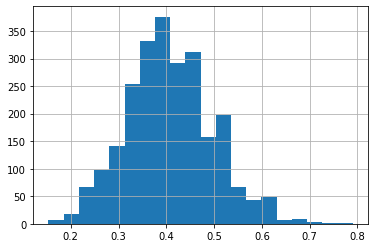

In [16]:
prob_df.actual_prob.hist(bins=20)

In [17]:
holdout=pd.read_csv('Holdout_Dataset.csv')
holdout.issue_d=pd.to_datetime(holdout.issue_d)
finaldf=holdout.loc[holdout.issue_d>'2018-01',:]

# The return rate distribution

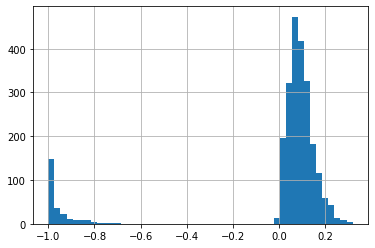

In [18]:
finaldf.return_rate.hist(bins=50)

# Variance of each loan

In [19]:
probability_of_default=prob_df['actual_prob'].values

In [20]:
loan_variance=probability_of_default*(def_rate-finaldf.return_rate.values)**2+\
(1-probability_of_default)*(paid_rate-finaldf.return_rate.values)**2

# The variance distribution 

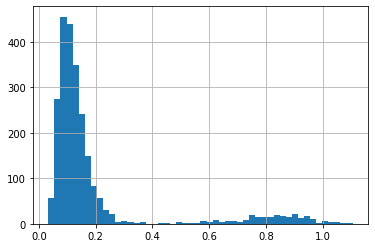

In [21]:
pd.Series(loan_variance).hist(bins=50)

# Putting it all together into the final dataframe

In [22]:
finaldf.head()

,acc_now_delinq,addr_state,all_util,annual_inc,application_type,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,grade,home_ownership,il_util,initial_list_status,inq_last_12m,int_rate,issue_d,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,num_accts_ever_120_pd,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,num_il_tl,pct_tl_nvr_dlq,pub_rec,pub_rec_bankruptcies,purpose,revol_util,sub_grade,tax_liens,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,loan_status,fico_score,active_rev_acct_frac,active_ins_acct_frac,total_payout,duration,return_rate,credit_hist,treasury_rate,unemp_rate_3mon
4,0.0,NY,29.0,63000.0,Individual,0.0,0.00000,0.0,0.0,9.47,2,4800.0,A,RENT,71.0,f,0.0,6.19,2018-06-01,0.0,-999.0,-999.0,-999.0,0.0,12.0,0.0,2.0,14.0,12.0,100.0,0.0,0.0,debt_consolidation,1.8,A2,0.0,36,0.0,19481.0,67055.0,24.0,34900.0,26455.0,40600.0,Not Verified,Fully Paid,792.0,0.083333,0.500000,4924.90,0.584703,0.044913,13.175342,2.65,3.93
32,0.0,MI,62.0,63000.0,Individual,0.0,0.00000,0.0,0.0,15.60,10,10000.0,C,MORTGAGE,126.0,w,3.0,13.58,2018-05-01,3.0,-999.0,-999.0,-999.0,0.0,23.0,0.0,5.0,28.0,23.0,100.0,0.0,0.0,home_improvement,1.1,C2,0.0,60,0.0,248981.0,314286.0,48.0,87300.0,162386.0,110900.0,Source Verified,Fully Paid,757.0,0.130435,0.565217,10360.43,0.335388,0.111350,14.843836,2.82,3.90
40,0.0,CA,72.0,42000.0,Individual,0.0,0.77181,0.0,0.0,34.46,10,16000.0,F,RENT,87.0,w,8.0,28.72,2018-02-01,0.0,79.0,-999.0,-999.0,0.0,11.0,0.0,7.0,13.0,8.0,94.7,0.0,0.0,debt_consolidation,4.6,F1,0.0,60,2832.0,60023.0,83725.0,19.0,11600.0,68325.0,15400.0,Verified,Fully Paid,677.0,0.181818,0.250000,17956.18,0.494292,0.262830,11.764384,2.60,4.53
51,0.0,CA,60.0,60000.0,Individual,0.0,0.00000,0.0,0.0,34.50,6,5000.0,E,RENT,44.0,f,1.0,24.37,2018-09-01,8.0,-999.0,-999.0,-999.0,0.0,16.0,0.0,1.0,13.0,3.0,100.0,0.0,0.0,debt_consolidation,72.2,E2,0.0,36,0.0,45574.0,75471.0,19.0,28700.0,31371.0,44100.0,Source Verified,Fully Paid,662.0,0.562500,0.333333,5060.92,0.165525,0.075906,6.838356,2.84,4.23
58,0.0,TX,83.0,175000.0,Individual,0.0,0.00000,0.0,0.0,18.36,10,32000.0,B,MORTGAGE,78.0,w,2.0,9.43,2018-02-01,12.0,36.0,-999.0,-999.0,0.0,13.0,0.0,1.0,14.0,15.0,86.1,0.0,0.0,debt_consolidation,87.4,B1,0.0,36,0.0,323873.0,349846.0,36.0,16900.0,92406.0,44800.0,Source Verified,Fully Paid,672.0,0.692308,0.200000,32638.80,0.244977,0.084029,23.772603,2.36,4.10


In [23]:
finaldf.reset_index(drop=True,inplace=True)

In [24]:
ultimate_df=pd.concat([finaldf,pd.DataFrame(loan_variance,columns=['loan_variance']),\
           pd.DataFrame(predicted_duration,columns=['expected_duration']),prob_df['actual_prob']],axis=1)

In [25]:
ultimate_df.head()

,acc_now_delinq,addr_state,all_util,annual_inc,application_type,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,delinq_amnt,dti,emp_length,funded_amnt,grade,home_ownership,il_util,initial_list_status,inq_last_12m,int_rate,issue_d,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,num_accts_ever_120_pd,num_rev_accts,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,num_il_tl,pct_tl_nvr_dlq,pub_rec,pub_rec_bankruptcies,purpose,revol_util,sub_grade,tax_liens,term,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bc_limit,total_il_high_credit_limit,total_rev_hi_lim,verification_status,loan_status,fico_score,active_rev_acct_frac,active_ins_acct_frac,total_payout,duration,return_rate,credit_hist,treasury_rate,unemp_rate_3mon,loan_variance,expected_duration,actual_prob
0,0.0,NY,29.0,63000.0,Individual,0.0,0.00000,0.0,0.0,9.47,2,4800.0,A,RENT,71.0,f,0.0,6.19,2018-06-01,0.0,-999.0,-999.0,-999.0,0.0,12.0,0.0,2.0,14.0,12.0,100.0,0.0,0.0,debt_consolidation,1.8,A2,0.0,36,0.0,19481.0,67055.0,24.0,34900.0,26455.0,40600.0,Not Verified,Fully Paid,792.0,0.083333,0.500000,4924.90,0.584703,0.044913,13.175342,2.65,3.93,0.099650,2.096265,0.403116
1,0.0,MI,62.0,63000.0,Individual,0.0,0.00000,0.0,0.0,15.60,10,10000.0,C,MORTGAGE,126.0,w,3.0,13.58,2018-05-01,3.0,-999.0,-999.0,-999.0,0.0,23.0,0.0,5.0,28.0,23.0,100.0,0.0,0.0,home_improvement,1.1,C2,0.0,60,0.0,248981.0,314286.0,48.0,87300.0,162386.0,110900.0,Source Verified,Fully Paid,757.0,0.130435,0.565217,10360.43,0.335388,0.111350,14.843836,2.82,3.90,0.180761,2.275114,0.429398
2,0.0,CA,72.0,42000.0,Individual,0.0,0.77181,0.0,0.0,34.46,10,16000.0,F,RENT,87.0,w,8.0,28.72,2018-02-01,0.0,79.0,-999.0,-999.0,0.0,11.0,0.0,7.0,13.0,8.0,94.7,0.0,0.0,debt_consolidation,4.6,F1,0.0,60,2832.0,60023.0,83725.0,19.0,11600.0,68325.0,15400.0,Verified,Fully Paid,677.0,0.181818,0.250000,17956.18,0.494292,0.262830,11.764384,2.60,4.53,0.228007,2.241744,0.509418
3,0.0,CA,60.0,60000.0,Individual,0.0,0.00000,0.0,0.0,34.50,6,5000.0,E,RENT,44.0,f,1.0,24.37,2018-09-01,8.0,-999.0,-999.0,-999.0,0.0,16.0,0.0,1.0,13.0,3.0,100.0,0.0,0.0,debt_consolidation,72.2,E2,0.0,36,0.0,45574.0,75471.0,19.0,28700.0,31371.0,44100.0,Source Verified,Fully Paid,662.0,0.562500,0.333333,5060.92,0.165525,0.075906,6.838356,2.84,4.23,0.098115,1.861142,0.329555
4,0.0,TX,83.0,175000.0,Individual,0.0,0.00000,0.0,0.0,18.36,10,32000.0,B,MORTGAGE,78.0,w,2.0,9.43,2018-02-01,12.0,36.0,-999.0,-999.0,0.0,13.0,0.0,1.0,14.0,15.0,86.1,0.0,0.0,debt_consolidation,87.4,B1,0.0,36,0.0,323873.0,349846.0,36.0,16900.0,92406.0,44800.0,Source Verified,Fully Paid,672.0,0.692308,0.200000,32638.80,0.244977,0.084029,23.772603,2.36,4.10,0.116672,2.084484,0.486257


# Characterizing into SAFE, NEUTRAL, RISKY DATAFRAMES

In [26]:
safe=ultimate_df.loc[ultimate_df.loan_variance<0.10,:]

In [27]:
neutral=ultimate_df.loc[(ultimate_df.loan_variance>0.10) & (ultimate_df.loan_variance<0.2),:]

In [28]:
risky=ultimate_df.loc[(ultimate_df.loan_variance>0.2),:]

In [29]:
safe.grade.value_counts()

A    325
B    261
C    176
D     73
E      6
Name: grade, dtype: int64

In [30]:
neutral.grade.value_counts()

B    353
C    351
A    234
D    210
E     38
F      6
Name: grade, dtype: int64

In [31]:
risky.grade.value_counts()

D    131
C     97
E     82
B     56
F     19
A      6
G      5
Name: grade, dtype: int64

In [33]:
safe_df=safe.sort_values(by='return_rate',ascending=False).iloc[0:50,:]
safe_df.reset_index(drop=True,inplace=True)
safe_df.drop(['application_type'],axis=1,inplace=True)

In [34]:
neutral_df=neutral.sort_values(by='return_rate',ascending=False).iloc[0:50,:]
neutral_df.reset_index(drop=True,inplace=True)
neutral_df.drop(['application_type'],axis=1,inplace=True)

In [35]:
risky_df=risky.sort_values(by='return_rate',ascending=False).iloc[0:50,:]
risky_df.reset_index(drop=True,inplace=True)
risky_df.drop(['application_type'],axis=1,inplace=True)

In [36]:
safe_df.to_csv('safe_df.csv')
neutral_df.to_csv('neutral_df.csv')
risky_df.to_csv('risky_df.csv')